# Домашнее задание

**Цель:** accuracy > 0.6 на паблик-лидерборде Kaggle.

**Порядок:**
- Загрузка CSV (./data/digit/train.csv, ./data/digit/test.csv)
- HOG-признаки (скользящее окно по 28×28), нормализация
- LinearSVC (линейный SVM) в `Pipeline`
- Валидация на hold-out, матрица ошибок
- Формирование `submission.csv`

In [5]:
# Библиотеки
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from sklearn.svm import LinearSVC

from skimage.feature import hog

# Убираем лишние предупреждения ради чистоты вывода
import warnings
warnings.filterwarnings('ignore')

## 1) Загрузка данных

In [6]:
# Пути к CSV из соревнования Kaggle Digit Recognizer
TRAIN_PATH = './data/digit/train.csv'
TEST_PATH  = './data/digit/test.csv'

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print(train_df.shape, test_df.shape)
train_df.head()[:3]

(42000, 785) (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2) Визуализация нескольких примеров

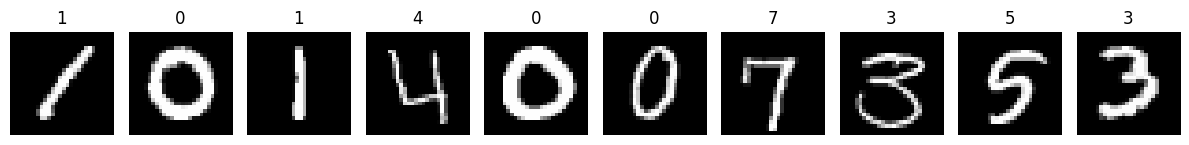

In [7]:
def plot_samples(images, labels=None, n=10):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        title = str(labels[i]) if labels is not None else ''
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    
X_pixels = train_df.drop(columns=['label']).values.astype(np.uint8)
y = train_df['label'].values.astype(np.uint8)

plot_samples(X_pixels, y, n=10)

## 3) Функция извлечения HOG-признаков
Подбираемые параметры HOG (по умолчанию работают хорошо):
- `pixels_per_cell=(4, 4)`
- `cells_per_block=(2, 2)`
- `orientations=9`

In [8]:
def extract_hog_batch(X_flat, pixels_per_cell=(4,4), cells_per_block=(2,2), orientations=9):
    # X_flat: (n_samples, 784) в виде uint8/float
    X_hog = []
    for row in X_flat:
        img = row.reshape(28, 28)
        feat = hog(img,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys',
                   visualize=False,
                   feature_vector=True)
        X_hog.append(feat)
    return np.array(X_hog, dtype=np.float32)

# Пробное извлечение (на небольшой подвыборке — быстро)
_ = extract_hog_batch(X_pixels[:5])
print("HOG extraction OK, sample feature length:", _.shape[1])

HOG extraction OK, sample feature length: 1296


## 4) Разделение на train/val и извлечение HOG

In [9]:
X_train_px, X_val_px, y_train, y_val = train_test_split(
    X_pixels, y, test_size=0.15, random_state=42, stratify=y
)

# Извлекаем HOG-фичи
X_train_hog = extract_hog_batch(X_train_px)
X_val_hog   = extract_hog_batch(X_val_px)

print(X_train_hog.shape, X_val_hog.shape)

(35700, 1296) (6300, 1296)


## 5) Модель: Linear SVM в пайплайне со стандартизацией

In [10]:
# LinearSVC часто хорошо работает на HOG; C=1.0 — базовый старт
clf = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svm', LinearSVC(C=1.0, max_iter=4000, dual=True))
])

clf.fit(X_train_hog, y_train)

pred_val = clf.predict(X_val_hog)
acc = accuracy_score(y_val, pred_val)
print(f'Validation accuracy: {acc:.4f}')

Validation accuracy: 0.9687


### Классификационный отчёт и матрица ошибок

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       620
           1       0.98      0.99      0.98       703
           2       0.97      0.97      0.97       627
           3       0.98      0.96      0.97       653
           4       0.97      0.96      0.96       611
           5       0.97      0.96      0.96       569
           6       0.98      0.98      0.98       620
           7       0.97      0.97      0.97       660
           8       0.97      0.94      0.96       609
           9       0.93      0.96      0.94       628

    accuracy                           0.97      6300
   macro avg       0.97      0.97      0.97      6300
weighted avg       0.97      0.97      0.97      6300



<Figure size 600x600 with 0 Axes>

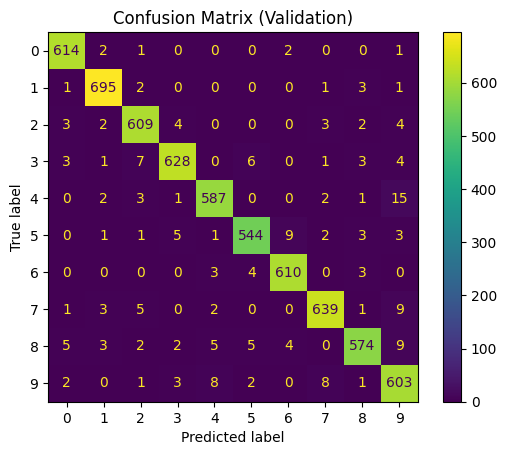

In [11]:
print(classification_report(y_val, pred_val))

fig = plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_val, pred_val)
plt.title('Confusion Matrix (Validation)')
plt.show()

## 6) Обучение на **всей** обучающей выборке и предсказание для теста
Перестроим HOG на всех train и на test, затем обучим финальную модель и сохраним submission.

In [12]:
# HOG на всём train и на test
X_all_px = train_df.drop(columns=['label']).values.astype(np.uint8)
y_all    = train_df['label'].values.astype(np.uint8)
X_test_px = test_df.values.astype(np.uint8)

X_all_hog  = extract_hog_batch(X_all_px)
X_test_hog = extract_hog_batch(X_test_px)

final_clf = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svm', LinearSVC(C=1.0, max_iter=5000, dual=True))
])
final_clf.fit(X_all_hog, y_all)

test_pred = final_clf.predict(X_test_hog)

# Формируем submission
sub = pd.DataFrame({
    'ImageId': np.arange(1, len(test_pred)+1),
    'Label': test_pred
})
sub_path = 'submission.csv'
sub.to_csv(sub_path, index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
